# Trying Different Approach

# Packages

In [1]:
import pandas as pd
import numpy as np
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
import yfinance as yf
from pypfopt.hierarchical_portfolio import HRPOpt
from pypfopt import plotting
import matplotlib.pyplot as plt

In [21]:
stock = ['BBCA.JK', 'BBRI.JK', 'BMRI.JK', 'BBNI.JK', 'ARTO.JK', 
         'BBTN.JK','HRUM.JK', 'INCO.JK', 'ANTM.JK', 'ADRO.JK','TKIM.JK','SMGR.JK', 
         'TLKM.JK', 'UNVR.JK', 'ASII.JK', 'BRPT.JK', 'PTPP.JK', 'CTRA.JK', 'TOWR.JK', 'SRTG.JK']
year = 2020
ds = str(year-2)+'-12-01'
de = str(year+1)+'-12-01'
df = pd.DataFrame(columns=stock)
for i in stock :
    temp = yf.Ticker(i).history(period = '2y', start = ds ,end =de ,interval = '1d',actions=False).dropna()[['Close']]
    log_return = np.log(temp['Close']/temp['Close'].shift(1)).dropna()
    df[i] = log_return

# HRP Model

Expected annual return: 12.4%
Annual volatility: 23.3%
Sharpe Ratio: 0.53


<AxesSubplot: >

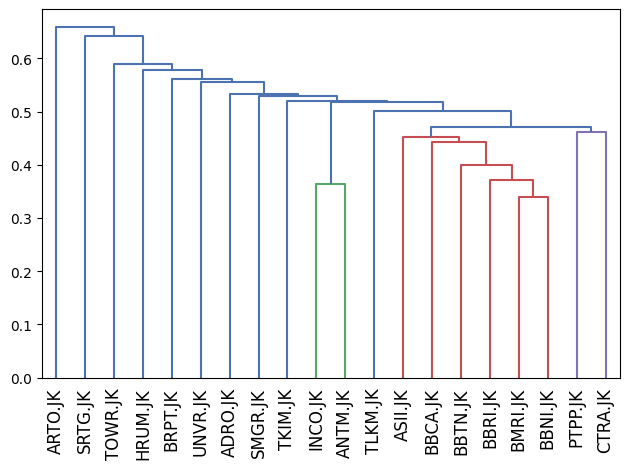

In [22]:
hrp = HRPOpt(df)
weights = hrp.optimize()
hrp.portfolio_performance(verbose = True, risk_free_rate = 0, frequency = 252)
plotting.plot_dendrogram(hrp)  # to plot dendrogram

In [23]:
print(weights)

OrderedDict([('ADRO.JK', 0.04878860479267642), ('ANTM.JK', 0.028292027211744127), ('ARTO.JK', 0.00960199102239063), ('ASII.JK', 0.05967246924420971), ('BBCA.JK', 0.07849839969193291), ('BBNI.JK', 0.04269432369750393), ('BBRI.JK', 0.04509742876888841), ('BBTN.JK', 0.026773332284966818), ('BMRI.JK', 0.04387156722072987), ('BRPT.JK', 0.041228749761181724), ('CTRA.JK', 0.015177803428768004), ('HRUM.JK', 0.05527276593487558), ('INCO.JK', 0.030383413339464326), ('PTPP.JK', 0.01397568515549107), ('SMGR.JK', 0.04847466652539863), ('SRTG.JK', 0.09888436145692749), ('TKIM.JK', 0.017500571334371152), ('TLKM.JK', 0.08676374401468587), ('TOWR.JK', 0.09997765055002653), ('UNVR.JK', 0.1090704445637668)])


In [24]:
weight_hrp = []
for i in weights.keys():
    temp = weights[i]
    weight_hrp.append(temp)
weight_hrp = np.round(weight_hrp,5)

In [25]:
port_ = dict(zip(stock,weight_hrp))
port = dict()
for (key,value) in port_.items():
    if value >0 : 
        port[key] = value
        
start = 2e7 
budget_ = dict()
for (key,value) in port.items():
    if value >0 : 
        budget_[key] = value*start
budget_

budget = pd.DataFrame.from_dict(data= budget_, orient= 'index').T
budget.rename(index={0: 'Total Spread'}, inplace= True)
budget

expense = pd.DataFrame(columns=port.keys())
for item in port.keys(): 
    temp = yf.Ticker(item).history(period = '1d', interval = '1mo',actions=False)
    expense[item] = temp['Close']*100 #1 lot
expense.rename(index={expense.index[0]: str('Closing ' + str(expense.index[0]).split(' ')[0])}, inplace= True)
expense

qty = pd.concat([expense,budget])
temp_ = pd.DataFrame(np.round(qty.iloc[1] / qty.iloc[0],0)).T
temp_.rename(index={0: 'Total Lot'}, inplace= True)
qty = pd.concat([qty, temp_])
spend = pd.DataFrame(np.round(qty.iloc[2] * qty.iloc[0],0)).T
finale = pd.concat([qty, spend])
finale.rename(index={0: 'Total Spending'}, inplace= True)
finale

,BBCA.JK,BBRI.JK,BMRI.JK,BBNI.JK,ARTO.JK,BBTN.JK,HRUM.JK,INCO.JK,ANTM.JK,ADRO.JK,TKIM.JK,SMGR.JK,TLKM.JK,UNVR.JK,ASII.JK,BRPT.JK,PTPP.JK,CTRA.JK,TOWR.JK,SRTG.JK
Closing 2022-10-06,842500.0,451000.0,932500.0,890000.0,695000.0,145000.0,182500.0,672500.0,193000.0,410000.0,767500.0,732500.0,443000.0,490000.0,660000.0,81000.0,91500.0,96000.0,121000.0,280000.0
Total Spread,975800.0,565800.0,192000.0,1193400.0,1570000.0,853800.0,902000.0,535400.0,877400.0,824600.0,303600.0,1105400.0,607600.0,279600.0,969400.0,1977600.0,350000.0,1735200.0,1999600.0,2181400.0
Total Lot,1.0,1.0,0.0,1.0,2.0,6.0,5.0,1.0,5.0,2.0,0.0,2.0,1.0,1.0,1.0,24.0,4.0,18.0,17.0,8.0
Total Spending,842500.0,451000.0,0.0,890000.0,1390000.0,870000.0,912500.0,672500.0,965000.0,820000.0,0.0,1465000.0,443000.0,490000.0,660000.0,1944000.0,366000.0,1728000.0,2057000.0,2240000.0


In [26]:
mu = df.mean()
C = df.corr()

In [27]:
print(f'return :', weight_hrp.dot(mu)*100, '%')
print(f'risk :', weight_hrp.dot(C).dot(weight_hrp)*100, '%')
print(f'Total Money :',finale.sum(axis=1)[-1])
print(f'Total Idle Money :', start - finale.sum(axis=1)[-1])

return : 0.09979255056980503 %
risk : 29.77783588417483 %
Total Money : 19206500.0
Total Idle Money : 793500.0


In [28]:
test = pd.DataFrame(columns = finale.columns)
for i in finale.columns :
    temp = yf.Ticker(i).history(period = '1y', start = '2021-12-31', interval = '1mo',actions=False).dropna()[['Close']][:-1]
    log_return = np.log(temp['Close']/temp['Close'].shift(1)).dropna()
    test[i] = log_return

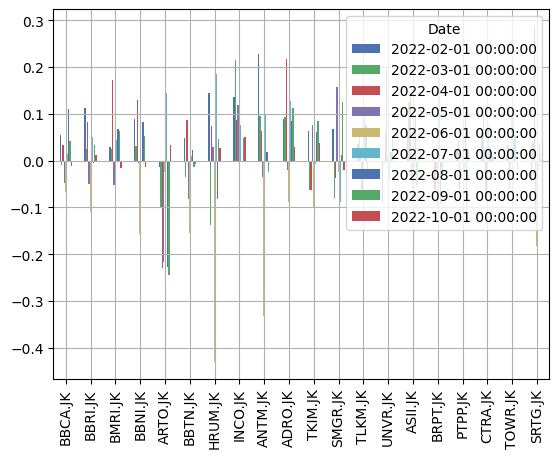

In [29]:
test.T.plot.bar()
plt.grid(True)
plt.show()

In [30]:
test['total_return'] = test.dot(weight_hrp)
test

,BBCA.JK,BBRI.JK,BMRI.JK,BBNI.JK,ARTO.JK,BBTN.JK,HRUM.JK,INCO.JK,ANTM.JK,ADRO.JK,...,SMGR.JK,TLKM.JK,UNVR.JK,ASII.JK,BRPT.JK,PTPP.JK,CTRA.JK,TOWR.JK,SRTG.JK,total_return
Date,,,,,,,,,,,,,,,,,,,,,
2022-02-01,0.054240,0.111484,0.029656,0.088148,-0.013814,0.049072,0.144355,0.136711,0.226528,0.089612,...,0.068249,0.035174,-0.090854,0.057666,0.000000,0.026527,0.055570,0.009709,-0.044617,0.044856
2022-03-01,-0.009360,0.023888,0.025642,0.030772,-0.099027,-0.034387,-0.137321,0.215709,0.094491,0.093453,...,-0.079464,0.053825,-0.005450,0.125417,0.016713,0.041031,0.117182,0.033257,0.037318,0.022876
2022-04-01,0.033844,0.082954,0.171365,0.129987,-0.229134,0.086198,0.074275,0.085767,0.063513,0.216430,...,-0.038319,0.008696,0.060946,0.141579,-0.062699,-0.062196,0.023754,-0.057708,0.287682,0.041742
2022-05-01,-0.047253,-0.050537,-0.051587,-0.005435,-0.217260,-0.081851,0.029917,0.119304,-0.035229,-0.021181,...,0.157780,-0.069457,0.195516,-0.030153,-0.017805,0.000000,-0.078088,-0.009950,-0.131963,-0.037859
2022-06-01,-0.066691,-0.109449,-0.070044,-0.155969,-0.024293,-0.155622,-0.429973,-0.375523,-0.332496,-0.088922,...,-0.024265,-0.074644,0.008421,-0.077906,-0.096876,0.010638,-0.135709,0.095310,-0.183126,-0.112967
2022-07-01,0.013699,0.049364,0.043217,0.000000,0.144739,0.010257,0.184919,0.076633,0.098219,0.127833,...,-0.087969,0.091831,-0.038969,-0.046340,0.175677,-0.037740,0.072861,0.084697,-0.023257,0.058232
2022-08-01,0.109434,-0.004598,0.067179,0.082489,-0.227289,0.023530,-0.081851,0.000000,0.017744,0.085472,...,0.011429,0.075121,0.017583,0.097822,-0.093090,0.104261,0.026668,0.053843,0.034686,0.007474
2022-09-01,0.041797,0.033978,0.062948,0.051440,-0.244134,-0.013378,0.045985,0.048009,-0.025447,0.112117,...,0.124494,-0.022174,0.050966,-0.051482,-0.030962,-0.132118,0.015251,-0.004040,0.003781,-0.004526
2022-10-01,-0.011765,0.011074,-0.016043,-0.014025,0.033523,-0.006757,0.027703,0.049534,0.000000,0.029853,...,-0.020271,0.000000,0.000000,0.007519,0.012500,0.022347,0.010471,-0.020451,0.040671,0.009624


In [31]:
test.total_return.mean()

0.0032724877803495178

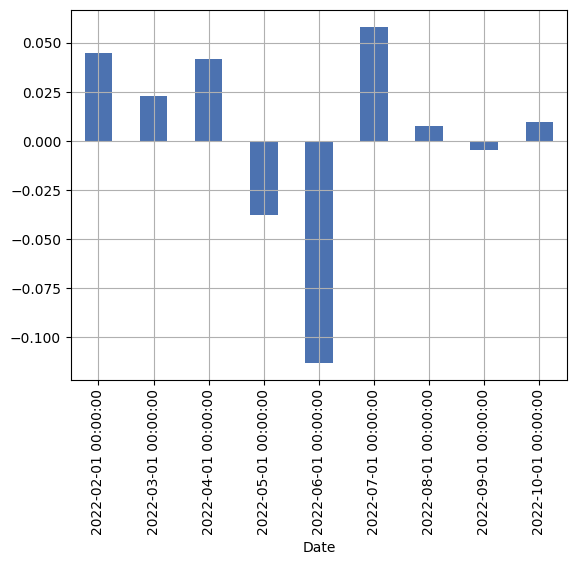

In [32]:
test.total_return.plot.bar()
plt.grid(True)
plt.show()